# Librerias

In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time
import math
import logging

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#acceder y mostrar datasets
%cd '/content/drive/MyDrive/Cacao_BDA'
!ls

/content/drive/MyDrive/Cacao_BDA
Monilia  Sana


# Carga y analisis de dataset

In [5]:
fpath = '/content/drive/MyDrive/Cacao_BDA'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Monilia', 'Sana'] 

No. of categories =  2


In [6]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
    
            img_lst.append(np.array(img_array))        
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1291 
No. of labels loaded =  1291
<class 'list'> <class 'list'>


In [7]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1291, 316, 212, 3) 
Labels shape =  (1291,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Cacao : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

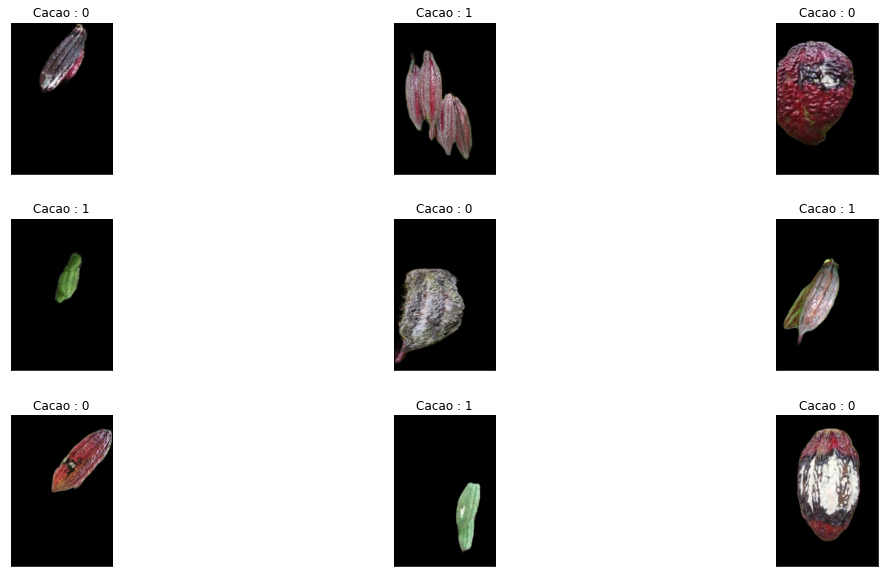

In [9]:
#mostrar imagenes
display_rand_images(images, labels)

# Preparar datos para entrenamiento del modelo

In [10]:
#obtener indices de valores de imgs
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#mezclar indices
np.random.seed(8)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1288 1289 1290]

'n' values after shuffling =  [319 881  22 ... 133 361 451]


In [11]:
#asignar indices correspondientes en las listas declaradas
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1291, 316, 212, 3) 
Labels shape after shuffling =  (1291,)


In [12]:
#normalizar contenido de listas
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1291, 316, 212, 3)


# Division de datos de entrenamiento y prueba

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 8)

x_val = x_train[:258]
y_val = y_train[:258]
x_train = x_train[258:]
y_train = y_train[258:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (774, 316, 212, 3)
y_train shape =  (774,)

x_test shape =  (259, 316, 212, 3)
y_test shape =  (259,)

x_val shape =  (258, 316, 212, 3)
y_val shape =  (258,)


In [14]:
#codificar con One-hot Encod
y_train = to_categorical(y_train, 2 , dtype='int32')
y_test = to_categorical(y_test, 2, dtype='int32')
y_val = to_categorical(y_val, 2, dtype='int32')

In [16]:
y_train.shape

(774, 2)

# Modelo InceptionV3

In [17]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 0s 0us/step


In [18]:
#desactivar el entrenamiento por defecto
for layer in pre_trained_model.layers:
    layer.trainable = False

In [20]:
#obtener capas de entradas e intermedias
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
#agregar capas de finales
#x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)
model = tf.keras.Model(pre_trained_model.input, x)

## Entrenamiento

In [21]:
#'sparse_categorical_crossentropy tf.keras.losses.categorical_crossentropy'
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
#estructura del modelo
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 316, 212, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 157, 105, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 157, 105, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [23]:
steps_per_epoch = (x_train.shape[0]//32)
validation_steps = (x_val.shape[0]// 32)
#regularizar modelo
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [24]:
x_train.shape,y_train.shape

((774, 316, 212, 3), (774, 2))

In [25]:
history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 20,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = 32,
    callbacks=[es],
    verbose=1)

Epoch 1/20
24/24 [==============================] - 130s 5s/step - loss: 2.6848 - accuracy: 0.7344 - val_loss: 0.3177 - val_accuracy: 0.9023
Epoch 2/20
24/24 [==============================] - 122s 5s/step - loss: 0.5665 - accuracy: 0.8491 - val_loss: 0.4838 - val_accuracy: 0.8320
Epoch 3/20
24/24 [==============================] - 121s 5s/step - loss: 0.2967 - accuracy: 0.8841 - val_loss: 0.2893 - val_accuracy: 0.8867
Epoch 4/20
24/24 [==============================] - 122s 5s/step - loss: 0.2605 - accuracy: 0.8949 - val_loss: 0.1946 - val_accuracy: 0.9219
Epoch 5/20
24/24 [==============================] - 121s 5s/step - loss: 0.1961 - accuracy: 0.9218 - val_loss: 0.2135 - val_accuracy: 0.9141
Epoch 6/20
24/24 [==============================] - 122s 5s/step - loss: 0.1684 - accuracy: 0.9353 - val_loss: 0.1840 - val_accuracy: 0.9414
Epoch 7/20
24/24 [==============================] - 122s 5s/step - loss: 0.1638 - accuracy: 0.9367 - val_loss: 0.2355 - val_accuracy: 0.9023
Epoch 8/20
24

In [26]:
model_json = model.to_json()
with open("/content/drive/MyDrive/NotebooksCocoaVision/Inceptionv3_v2.json", "w") as json_file:
    json_file.write(model_json)
model.save("/content/drive/MyDrive/NotebooksCocoaVision/InceptionV3_cocoaClassifier_v1_1.h5")
print("Saved model to disk")
model.save_weights("/content/drive/MyDrive/NotebooksCocoaVision/InceptionV3_WCocoa_v1_1.h5")

Saved model to disk


# Visualizar estado de entrenamiento

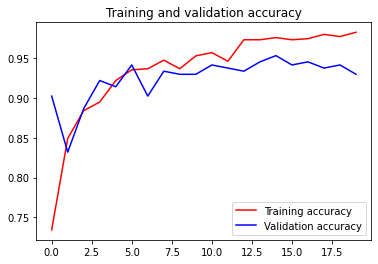

In [27]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

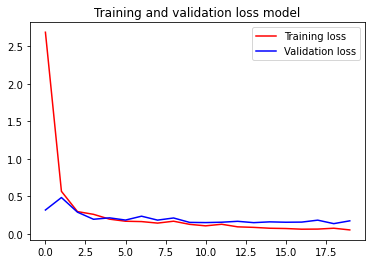

In [29]:
accuracy = history.history['loss']
validation_accuracy = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training loss')
plt.plot(epochs, validation_accuracy, 'b', label='Validation loss')
plt.title('Training and validation loss model')
plt.legend(loc=0)
plt.show()

# Evaluacion del modelo

In [31]:
model.evaluate(x_test,y_test,batch_size=32)

9/9 [==============================] - 32s 3s/step - loss: 0.1993 - accuracy: 0.9266


[0.19926667213439941, 0.9266409277915955]

In [36]:
#realizar predicciones
y_pred = model.predict(x_test,batch_size=32,verbose=0)

In [37]:
#cambiar a 1 fila todas las predicciones
y_pred_reduce = np.argmax(y_pred, axis=1)

In [38]:
#cambiar a 1 fila todas las muestras prueba
y_test_reduced = np.argmax(y_test,axis=1)

[Text(0, 0.5, 'Monilia(0)'), Text(0, 1.5, 'Sana(1)')]

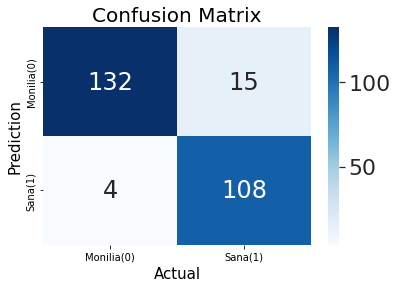

In [40]:
#crear matrix de confusion
cm= confusion_matrix(y_pred_reduce, y_test_reduced)
ax=plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)

#info
ax.set_xlabel('Actual',fontsize=15)
ax.set_ylabel('Prediction',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=20)
ax.xaxis.set_ticklabels(['Monilia(0)','Sana(1)'],fontsize=10)
ax.yaxis.set_ticklabels(['Monilia(0)','Sana(1)'],fontsize=10)

In [42]:
#metricas de evaluacion
print(classification_report(y_pred_reduce,y_test_reduced))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       147
           1       0.88      0.96      0.92       112

    accuracy                           0.93       259
   macro avg       0.92      0.93      0.93       259
weighted avg       0.93      0.93      0.93       259

